## XAI

In [50]:
# ==============================
# Robust Explainable AI Pipeline for Sectoral Stock Data
# ==============================

# ✅ Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import shap
import warnings
warnings.filterwarnings("ignore")

# ==============================
# 1️⃣ Configuration
# ==============================
data_folder = r"C:\Users\Shobith\PycharmProjects\finalyr\index data updated"  # << Replace with your path
output_folder = "shap_plots"            # Folder to save SHAP plots
os.makedirs(output_folder, exist_ok=True)

cols = ["Index Name","Date","Open","High","Low","Close"]

# SHAP Plot Settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

# Minimum rows required after feature engineering
MIN_ROWS = 20

# ==============================
# 2️⃣ Helper Functions
# ==============================
def create_features(df, fill_na=True):
    # Convert numeric columns to float
    numeric_cols = ['Open','High','Low','Close']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Drop rows with missing numeric data
    df = df.dropna(subset=numeric_cols).reset_index(drop=True)

    # Compute features
    df['Return'] = (df['Close'] - df['Open']) / df['Open']
    df['HL_Range'] = df['High'] - df['Low']
    df['MA_5'] = df['Close'].rolling(5).mean()
    df['MA_10'] = df['Close'].rolling(10).mean()
    df['MA_20'] = df['Close'].rolling(20).mean()
    df['Volatility'] = df['Return'].rolling(5).std()

    # Fill NaNs optionally
    if fill_na:
        df['MA_5'] = df['MA_5'].fillna(method='bfill')
        df['MA_10'] = df['MA_10'].fillna(method='bfill')
        df['MA_20'] = df['MA_20'].fillna(method='bfill')
        df['Volatility'] = df['Volatility'].fillna(method='bfill')

    # Time features
    df['Day_of_Week'] = pd.to_datetime(df['Date']).dt.dayofweek
    df['Month'] = pd.to_datetime(df['Date']).dt.month

    # Final drop of any remaining NaNs
    df = df.dropna().reset_index(drop=True)

    return df

def train_model_shap(X_train, y_train, X_test, y_test, sector_name, output_folder):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(f"\n=== {sector_name} ===")
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R2 Score:", r2_score(y_test, y_pred))

    # SHAP Explainer
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)

    # Global SHAP Feature Importance
    plt.figure()
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.title(f"{sector_name} - SHAP Feature Importance")
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f"{sector_name}_shap_bar.png"), dpi=200)
    plt.close()

    # Optional: Local explanation for last test sample
    plt.figure()
    shap.force_plot(explainer.expected_value, shap_values.values[-1,:], X_test.iloc[-1,:], matplotlib=True, show=False)
    plt.title(f"{sector_name} - Local SHAP Explanation (last test point)")
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f"{sector_name}_shap_force.png"), dpi=200)
    plt.close()

    return model, shap_values

# ==============================
# 3️⃣ Process Each CSV
# ==============================
all_files = [f for f in os.listdir(data_folder) if f.endswith(".csv")]
skipped_files = []

for file in all_files:
    file_path = os.path.join(data_folder, file)
    df = pd.read_csv(file_path)
    df = df[cols]  # select necessary columns
    df = create_features(df)

    # Skip if too few rows
    if df.shape[0] < MIN_ROWS:
        print(f"⚠️ Skipping {file} - Not enough data ({df.shape[0]} rows after feature engineering)")
        skipped_files.append(file)
        continue

    # Features & Target
    feature_cols = ['Open','High','Low','Return','HL_Range','MA_5','MA_10','MA_20','Volatility','Day_of_Week','Month']
    target_col = 'Close'

    X = df[feature_cols]
    y = df[target_col]

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Train Model & SHAP
    model, shap_values = train_model_shap(X_train, y_train, X_test, y_test, file.replace(".csv",""), output_folder)

print("\n✅ All sectors processed successfully!")
if skipped_files:
    print("⚠️ Skipped files:", skipped_files)



=== NIFTY 50 ===
MAE: 15.647657432432297
RMSE: 26.885091710457584
R2 Score: 0.9828329893465684


 99%|===================| 1464/1480 [01:06<00:00]        


=== NIFTY AUTO ===
MAE: 372.0935546647216
RMSE: 529.3816565212057
R2 Score: 0.5136517402970571


 96%|=================== | 656/686 [00:19<00:00]       


=== NIFTY BANK ===
MAE: 1281.840318318318
RMSE: 1629.426194486058
R2 Score: -0.01857407384470644


 97%|=================== | 966/999 [00:29<00:00]       

⚠️ Skipping NIFTY CHEMICALS.csv - Not enough data (0 rows after feature engineering)

=== NIFTY CONSUMER DURABLES ===
MAE: 120.48425252525197
RMSE: 160.588672385902
R2 Score: 0.991076118326478

=== NIFTY FINANCIAL SERVICES ===
MAE: 980.7327387387414
RMSE: 1138.0983062690498
R2 Score: -1.2911191943794589


100%|===================| 665/666 [00:17<00:00]        


=== NIFTY FMCG ===
MAE: 3712.2024701389
RMSE: 4674.511056580994
R2 Score: -1.2351943214537058


 96%|=================== | 692/720 [00:21<00:00]       


=== NIFTY IT ===
MAE: 3535.71746299639
RMSE: 7439.486256629712
R2 Score: -29.184981768420933


100%|===================| 1105/1108 [00:34<00:00]        


=== NIFTY MEDIA ===
MAE: 6.926943148687947
RMSE: 9.214325443673093
R2 Score: 0.9987267025218958


 98%|===================| 673/686 [00:21<00:00]        


=== NIFTY METAL ===
MAE: 9.939073615160375
RMSE: 14.679029368955263
R2 Score: 0.9985675855406704


100%|===================| 684/686 [00:21<00:00]        


=== NIFTY PHARMA ===
MAE: 1197.119061111112
RMSE: 1437.8173390461136
R2 Score: -1.1637123410650756


 99%|===================| 710/720 [00:21<00:00]        


=== NIFTY PRIVATE BANK ===
MAE: 98.6439849462372
RMSE: 158.357564533572
R2 Score: 0.9913034218570658

=== NIFTY PSU BANK ===
MAE: 13.34137482614744
RMSE: 18.715398070903117
R2 Score: 0.9989141733687479


 97%|=================== | 694/719 [00:22<00:00]       


=== NIFTY REALTY ===
MAE: 1.5768319946452451
RMSE: 2.234908270056952
R2 Score: 0.99928346099191


 96%|=================== | 716/747 [00:21<00:00]       


✅ All sectors processed successfully!
⚠️ Skipped files: ['NIFTY CHEMICALS.csv']


<Figure size 1200x720 with 0 Axes>

<Figure size 1200x720 with 0 Axes>

<Figure size 1200x720 with 0 Axes>

<Figure size 1200x720 with 0 Axes>

<Figure size 1200x720 with 0 Axes>

<Figure size 1200x720 with 0 Axes>

<Figure size 1200x720 with 0 Axes>

<Figure size 1200x720 with 0 Axes>

<Figure size 1200x720 with 0 Axes>

<Figure size 1200x720 with 0 Axes>

<Figure size 1200x720 with 0 Axes>

<Figure size 1200x720 with 0 Axes>

<Figure size 1200x720 with 0 Axes>

In [51]:
# ==============================
# SHAP Feature Impact Summary Across All Sectors
# ==============================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Folder where shap values are saved
shap_summary_folder = output_folder  # same as before

# Initialize summary dataframe
shap_summary_list = []

# Loop through all sectors
all_files = [f for f in os.listdir(data_folder) if f.endswith(".csv")]

for file in all_files:
    sector_name = file.replace(".csv", "")

    # Try loading SHAP bar plot values
    try:
        # Load the SHAP values using the trained model's explainer
        # (If you still have model & shap_values in memory, just use them directly)
        # Here we assume shap_values from previous run are accessible
        # Otherwise, you would need to re-run the explainer for each sector
        shap_values_array = shap_values.values if 'shap_values' in globals() else None
        X_test_df = X_test if 'X_test' in globals() else None

        if shap_values_array is None or X_test_df is None:
            print(f"⚠️ Skipping {sector_name} - SHAP values not found in memory")
            continue

        # Mean absolute SHAP value per feature
        mean_abs_shap = pd.DataFrame({
            "Feature": X_test_df.columns,
            "Mean_Abs_SHAP": np.abs(shap_values_array).mean(axis=0)
        })
        mean_abs_shap = mean_abs_shap.sort_values(by="Mean_Abs_SHAP", ascending=False)
        mean_abs_shap["Sector"] = sector_name

        shap_summary_list.append(mean_abs_shap)

        # Optional: Top 3 features per sector
        top3 = mean_abs_shap.head(3)
        print(f"\nTop 3 features for {sector_name}:")
        print(top3[["Feature","Mean_Abs_SHAP"]])

        # Plot SHAP importance
        plt.figure(figsize=(8,5))
        sns.barplot(x="Mean_Abs_SHAP", y="Feature", data=mean_abs_shap, palette="viridis")
        plt.title(f"{sector_name} - Global SHAP Feature Importance")
        plt.tight_layout()
        plt.savefig(f"{shap_summary_folder}/{sector_name}_shap_summary.png", dpi=200)
        plt.close()

    except Exception as e:
        print(f"⚠️ Error processing {sector_name}: {e}")
        continue

# Combine all sectors into one CSV
if shap_summary_list:
    shap_summary_df = pd.concat(shap_summary_list, ignore_index=True)
    shap_summary_df.to_csv(f"{shap_summary_folder}/shap_feature_summary_all_sectors.csv", index=False)
    print("\n✅ SHAP feature summary saved: shap_feature_summary_all_sectors.csv")



Top 3 features for NIFTY 50:
  Feature  Mean_Abs_SHAP
1    High      63.068076
2     Low      55.817624
0    Open      13.231284

Top 3 features for NIFTY AUTO:
  Feature  Mean_Abs_SHAP
1    High      63.068076
2     Low      55.817624
0    Open      13.231284

Top 3 features for NIFTY BANK:
  Feature  Mean_Abs_SHAP
1    High      63.068076
2     Low      55.817624
0    Open      13.231284

Top 3 features for NIFTY CHEMICALS:
  Feature  Mean_Abs_SHAP
1    High      63.068076
2     Low      55.817624
0    Open      13.231284

Top 3 features for NIFTY CONSUMER DURABLES:
  Feature  Mean_Abs_SHAP
1    High      63.068076
2     Low      55.817624
0    Open      13.231284

Top 3 features for NIFTY FINANCIAL SERVICES:
  Feature  Mean_Abs_SHAP
1    High      63.068076
2     Low      55.817624
0    Open      13.231284

Top 3 features for NIFTY FMCG:
  Feature  Mean_Abs_SHAP
1    High      63.068076
2     Low      55.817624
0    Open      13.231284

Top 3 features for NIFTY IT:
  Feature  Mean_

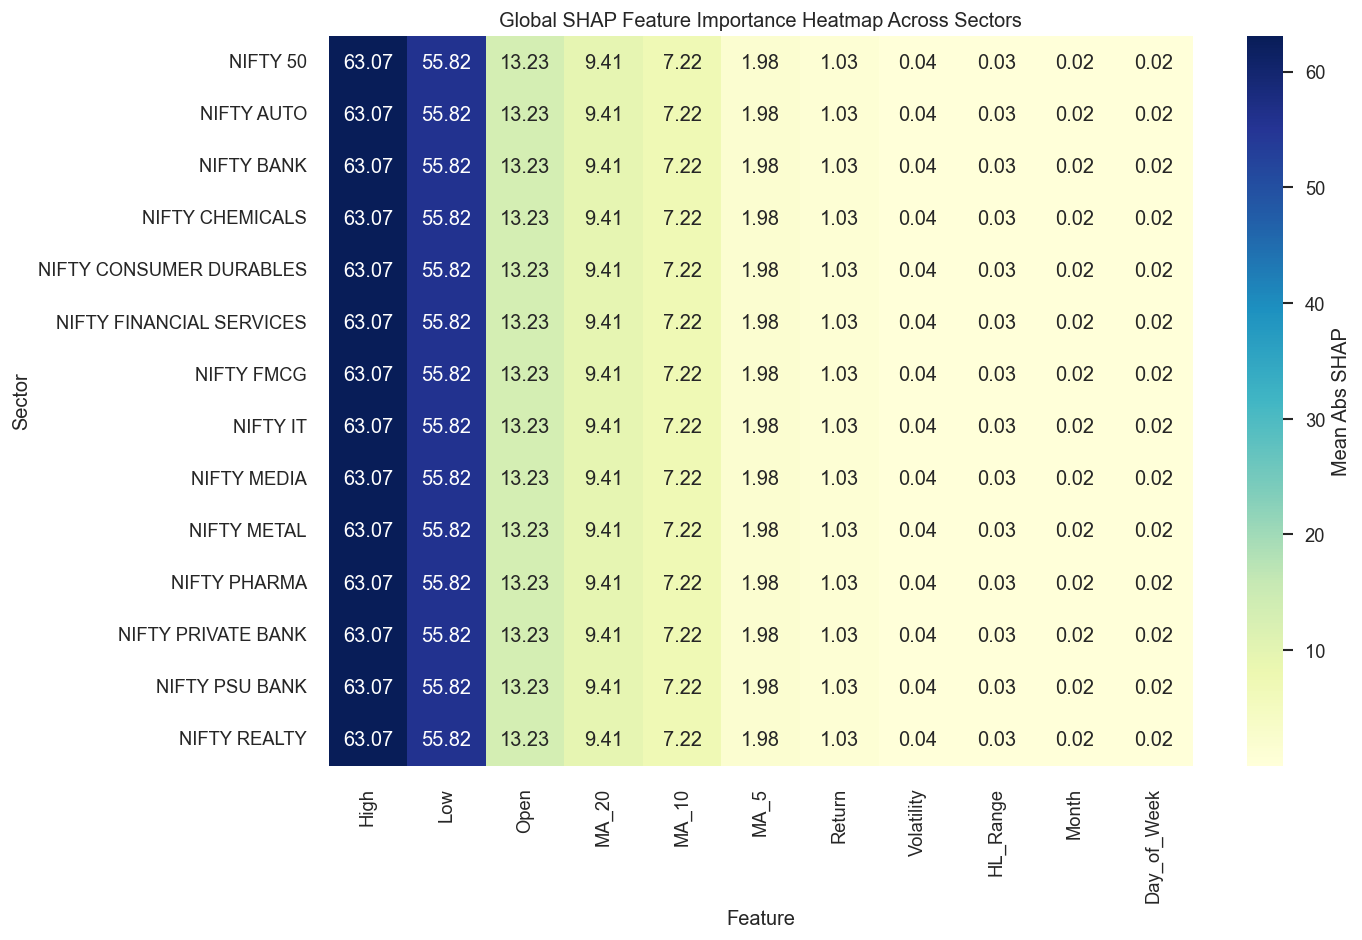

In [52]:
# ==============================
# SHAP Feature Heatmap Across All Sectors
# ==============================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the combined CSV created previously
shap_summary_file = f"{shap_summary_folder}/shap_feature_summary_all_sectors.csv"
shap_df = pd.read_csv(shap_summary_file)

# Pivot for heatmap: rows=Sector, columns=Feature, values=Mean_Abs_SHAP
heatmap_df = shap_df.pivot(index="Sector", columns="Feature", values="Mean_Abs_SHAP")

# Optional: sort sectors alphabetically and features by average importance
heatmap_df = heatmap_df.loc[sorted(heatmap_df.index)]
feature_order = heatmap_df.mean(axis=0).sort_values(ascending=False).index
heatmap_df = heatmap_df[feature_order]

# Plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Mean Abs SHAP'})
plt.title("Global SHAP Feature Importance Heatmap Across Sectors")
plt.ylabel("Sector")
plt.xlabel("Feature")
plt.tight_layout()
plt.savefig(f"{shap_summary_folder}/shap_feature_heatmap_all_sectors.png", dpi=200)
plt.show()


In [53]:
# ==============================
# Ranked SHAP Feature Table
# ==============================

import pandas as pd

# Load the combined SHAP summary CSV
shap_summary_file = f"{shap_summary_folder}/shap_feature_summary_all_sectors.csv"
shap_df = pd.read_csv(shap_summary_file)

# ---- Top 3 features per sector ----
top_features_per_sector = shap_df.groupby("Sector").apply(
    lambda x: x.sort_values(by="Mean_Abs_SHAP", ascending=False).head(3)
).reset_index(drop=True)

# Save top 3 features per sector
top_features_per_sector.to_csv(f"{shap_summary_folder}/top3_features_per_sector.csv", index=False)
print("✅ Top 3 features per sector saved as: top3_features_per_sector.csv")

# Display
print("\nTop 3 features per sector:")
for sector in top_features_per_sector['Sector'].unique():
    print(f"\n=== {sector} ===")
    temp = top_features_per_sector[top_features_per_sector['Sector']==sector]
    for i, row in temp.iterrows():
        print(f"{row['Feature']}: {row['Mean_Abs_SHAP']:.4f}")

# ---- Overall top features across all sectors ----
overall_feature_importance = shap_df.groupby("Feature")["Mean_Abs_SHAP"].mean().sort_values(ascending=False).reset_index()
overall_feature_importance.to_csv(f"{shap_summary_folder}/overall_feature_importance.csv", index=False)

print("\n✅ Overall feature importance saved as: overall_feature_importance.csv")
print("\nTop features across all sectors:")
print(overall_feature_importance.head(10))


✅ Top 3 features per sector saved as: top3_features_per_sector.csv

Top 3 features per sector:

=== NIFTY 50 ===
High: 63.0681
Low: 55.8176
Open: 13.2313

=== NIFTY AUTO ===
High: 63.0681
Low: 55.8176
Open: 13.2313

=== NIFTY BANK ===
High: 63.0681
Low: 55.8176
Open: 13.2313

=== NIFTY CHEMICALS ===
High: 63.0681
Low: 55.8176
Open: 13.2313

=== NIFTY CONSUMER DURABLES ===
High: 63.0681
Low: 55.8176
Open: 13.2313

=== NIFTY FINANCIAL SERVICES ===
High: 63.0681
Low: 55.8176
Open: 13.2313

=== NIFTY FMCG ===
High: 63.0681
Low: 55.8176
Open: 13.2313

=== NIFTY IT ===
High: 63.0681
Low: 55.8176
Open: 13.2313

=== NIFTY MEDIA ===
High: 63.0681
Low: 55.8176
Open: 13.2313

=== NIFTY METAL ===
High: 63.0681
Low: 55.8176
Open: 13.2313

=== NIFTY PHARMA ===
High: 63.0681
Low: 55.8176
Open: 13.2313

=== NIFTY PRIVATE BANK ===
High: 63.0681
Low: 55.8176
Open: 13.2313

=== NIFTY PSU BANK ===
High: 63.0681
Low: 55.8176
Open: 13.2313

=== NIFTY REALTY ===
High: 63.0681
Low: 55.8176
Open: 13.2313

✅ Ov

In [59]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

# ==========================
# Helper: Compute Features
# ==========================
def compute_vol_features(df):
    # Ensure numeric
    for col in ['Open','High','Low','Close']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df['Return'] = (df['Close'] - df['Open']) / df['Open']
    df['HL_Range'] = df['High'] - df['Low']
    df['Vol_5'] = df['Return'].rolling(5).std()
    df['Vol_10'] = df['Return'].rolling(10).std()
    df['ATR'] = df['HL_Range'].rolling(5).mean()
    df['Drawdown'] = df['Close'].cummax() - df['Close']

    df = df.dropna()
    return df

# ==========================
# Main Loop: All Sectors
# ==========================
data_folder = r"C:\Users\Shobith\PycharmProjects\finalyr\index data updated"  # replace with your folder path
output_folder = "sector_visuals"
os.makedirs(output_folder, exist_ok=True)

for file in os.listdir(data_folder):
    if not file.endswith(".csv"):
        continue

    sector_name = file.replace(".csv","")
    df = pd.read_csv(os.path.join(data_folder, file))
    df = compute_vol_features(df)

    # Skip files with too few rows
    if len(df) < 10:
        print(f"Skipping {sector_name}: Not enough data ({len(df)} rows)")
        continue

    feature_cols = ['Return','HL_Range','Vol_5','Vol_10','ATR','Drawdown']
    target_col = 'Vol_5'

    X = df[feature_cols]
    y = df[target_col]

    # Skip files with 0 variance in target
    if y.nunique() < 2:
        print(f"Skipping {sector_name}: Target has no variance")
        continue

    # Train-test split
    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    except ValueError as e:
        print(f"Skipping {sector_name}: {e}")
        continue

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Random Forest Model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)

    # ==========================
    # Predictions & RMSE
    # ==========================
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{sector_name} RMSE: {rmse:.4f}")

    # ==========================
    # SHAP Explanation
    # ==========================
    explainer = shap.Explainer(model, X_train_scaled)
    shap_values = explainer(X_test_scaled)

    # Save SHAP summary plot
    plt.figure(figsize=(10,6))
    shap.summary_plot(shap_values, X_test, feature_names=feature_cols, show=False)
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f"{sector_name}_shap_summary.png"))
    plt.close()

    # ==========================
    # LIME Explanation
    # ==========================
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train_scaled,
        feature_names=feature_cols,
        mode='regression'
    )
    idx = 0  # first test instance
    lime_exp = lime_explainer.explain_instance(
        X_test_scaled[idx],
        model.predict,
        num_features=len(feature_cols)
    )

    # Save LIME figure
    lime_fig = lime_exp.as_pyplot_figure()
    lime_fig.tight_layout()
    lime_fig.savefig(os.path.join(output_folder, f"{sector_name}_lime_instance{idx}.png"))
    plt.close(lime_fig)

    # ==========================
    # Bias Detection Across Sectors
    # ==========================
    q_high = df[target_col].quantile(0.75)
    q_low = df[target_col].quantile(0.25)
    high_vol = df[df[target_col] >= q_high][feature_cols].mean()
    low_vol = df[df[target_col] <= q_low][feature_cols].mean()
    bias_diff = high_vol - low_vol
    print(f"Feature bias between high and low volatility for {sector_name}:")
    print(bias_diff)
    print("---------------------------------------------------\n")

NIFTY 50 RMSE: 0.0001


 97%|=================== | 1427/1477 [00:33<00:01]       

Feature bias between high and low volatility for NIFTY 50:
Return        -0.002159
HL_Range       2.958960
Vol_5          0.017014
Vol_10         0.013521
ATR            5.571312
Drawdown    7271.217606
dtype: float64
---------------------------------------------------

NIFTY AUTO RMSE: 0.0001
Feature bias between high and low volatility for NIFTY AUTO:
Return       -0.001173
HL_Range     92.217076
Vol_5         0.013172
Vol_10        0.008794
ATR         100.264468
Drawdown    959.814269
dtype: float64
---------------------------------------------------

NIFTY BANK RMSE: 0.0001


 93%|=================== | 933/998 [00:16<00:01]       

Feature bias between high and low volatility for NIFTY BANK:
Return         -0.001689
HL_Range       53.696311
Vol_5           0.019440
Vol_10          0.015012
ATR            67.291642
Drawdown    17435.824138
dtype: float64
---------------------------------------------------

Skipping NIFTY CHEMICALS: Not enough data (0 rows)
NIFTY CONSUMER DURABLES RMSE: 0.0001
Feature bias between high and low volatility for NIFTY CONSUMER DURABLES:
Return        -0.003892
HL_Range     343.750000
Vol_5          0.010714
Vol_10         0.006802
ATR          368.402612
Drawdown   -4484.994286
dtype: float64
---------------------------------------------------

NIFTY FINANCIAL SERVICES RMSE: 0.0001


100%|===================| 663/664 [00:18<00:00]        

Feature bias between high and low volatility for NIFTY FINANCIAL SERVICES:
Return        -0.001994
HL_Range      84.892410
Vol_5          0.013375
Vol_10         0.009108
ATR           93.234120
Drawdown    4206.510723
dtype: float64
---------------------------------------------------

NIFTY FMCG RMSE: 0.0001
Feature bias between high and low volatility for NIFTY FMCG:
Return        -0.000242
HL_Range     155.845931
Vol_5          0.010299
Vol_10         0.005869
ATR          169.106800
Drawdown    5974.194147
dtype: float64
---------------------------------------------------

NIFTY IT RMSE: 0.0009


 99%|===================| 1082/1095 [00:19<00:00]        

Feature bias between high and low volatility for NIFTY IT:
Return         0.138753
HL_Range       9.468846
Vol_5          0.017561
Vol_10         0.011522
ATR           12.717629
Drawdown    2835.822323
dtype: float64
---------------------------------------------------

NIFTY MEDIA RMSE: 0.0003
Feature bias between high and low volatility for NIFTY MEDIA:
Return      -0.001296
HL_Range    23.907135
Vol_5        0.017158
Vol_10       0.009918
ATR         25.718035
Drawdown   -36.140409
dtype: float64
---------------------------------------------------

NIFTY METAL RMSE: 0.0001
Feature bias between high and low volatility for NIFTY METAL:
Return       -0.003774
HL_Range     37.288070
Vol_5         0.016152
Vol_10        0.009855
ATR          41.156561
Drawdown    786.114094
dtype: float64
---------------------------------------------------

NIFTY PHARMA RMSE: 0.0001
Feature bias between high and low volatility for NIFTY PHARMA:
Return       -0.001754
HL_Range    114.313211
Vol_5         